In [30]:
!pip install matplotlib opencv-python

In [31]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter

In [34]:
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
            
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [2]:
from preselection import retrieve

I will use a small hardcoded example located in /workspace/dataset22/.
The output directory is /tmp/



0it [00:00, ?it/s]
1it [00:00,  1.16it/s]
3it [00:00,  3.72it/s]
7it [00:01,  4.60it/s]
9it [00:01,  6.07it/s]
12it [00:01,  8.96it/s]
16it [00:02, 13.56it/s]
20it [00:02, 17.61it/s]
24it [00:02, 21.26it/s]
27it [00:02, 22.16it/s]
31it [00:02, 24.80it/s]
35it [00:02, 27.28it/s]
39it [00:02, 28.87it/s]
43it [00:02, 30.45it/s]
47it [00:03, 31.82it/s]
51it [00:03, 31.65it/s]
55it [00:03, 32.81it/s]
59it [00:03, 34.46it/s]
63it [00:03, 33.92it/s]
67it [00:03, 32.87it/s]
71it [00:03, 33.92it/s]
75it [00:03, 34.03it/s]
79it [00:03, 34.11it/s]
83it [00:04, 34.05it/s]
88it [00:04, 36.44it/s]
92it [00:04, 36.41it/s]
96it [00:04, 32.98it/s]
100it [00:04, 33.37it/s]
104it [00:04, 34.52it/s]
108it [00:04, 35.26it/s]
112it [00:04, 35.08it/s]
116it [00:05, 34.43it/s]
120it [00:05, 33.36it/s]
124it [00:05, 34.26it/s]
129it [00:05, 36.69it/s]
133it [00:05, 36.62it/s]
137it [00:05, 35.22it/s]
141it [00:05, 33.91it/s]
145it [00:05, 32.52it/s]
149it [00:06, 31.30it/s]
153it [00:06, 31.41it/s]
157it [00:

16:12:28.591 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (I47e296f116f4c218) - further warnings are suppressed



6754it [03:57, 18.26it/s]
6759it [03:57, 22.80it/s]
6764it [03:57, 27.19it/s]
6768it [03:58, 29.14it/s]
6772it [03:58, 30.89it/s]
6776it [03:58, 31.44it/s]
6780it [03:58, 31.43it/s]
6784it [03:58, 30.51it/s]
6788it [03:58, 30.40it/s]
6792it [03:58, 31.68it/s]
6796it [03:59, 21.72it/s]
6800it [03:59, 24.59it/s]
6804it [03:59, 26.76it/s]
6808it [03:59, 28.80it/s]
6812it [03:59, 30.49it/s]
6817it [03:59, 34.24it/s]
6821it [03:59, 33.54it/s]
6825it [03:59, 33.43it/s]
6829it [04:00, 32.99it/s]
6833it [04:00, 33.01it/s]
6837it [04:00, 33.85it/s]
6842it [04:00, 37.08it/s]
6846it [04:00, 25.40it/s]
6850it [04:00, 27.81it/s]
6854it [04:00, 29.66it/s]
6858it [04:01, 31.31it/s]
6862it [04:01, 31.76it/s]
6866it [04:01, 32.01it/s]
6870it [04:01, 32.50it/s]
6874it [04:01, 32.41it/s]
6878it [04:01, 32.60it/s]
6882it [04:01, 33.12it/s]
6886it [04:01, 32.86it/s]
6890it [04:02, 32.39it/s]
6894it [04:02, 31.83it/s]
6898it [04:02, 31.51it/s]
6902it [04:02, 31.73it/s]
6906it [04:02, 31.27it/s]
6910it [04:

16:21:22.407 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 2 empty documents


In [35]:
def load_queries():
    file_name = 'dataset22/topics.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

In [36]:
preselection_data = retrieve(queries.iloc[[0]])

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01q/s]


In [37]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append('dataset22/images/' + image_id[:3] + '/' + image_id + '/image.webp')
        
    return image_paths

In [48]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_id"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images

def get_sorted_images(images):
    topic_img = cv.cvtColor(cv.imread("image_results/topic_generated.png"), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image)
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    matched_images_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_matched_images_dataframe = matched_images_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_matched_images_dataframe)

In [49]:
def show_multiple_images(image_list, row_count, col_count):
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 120), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
    plt.show()

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78q/s]


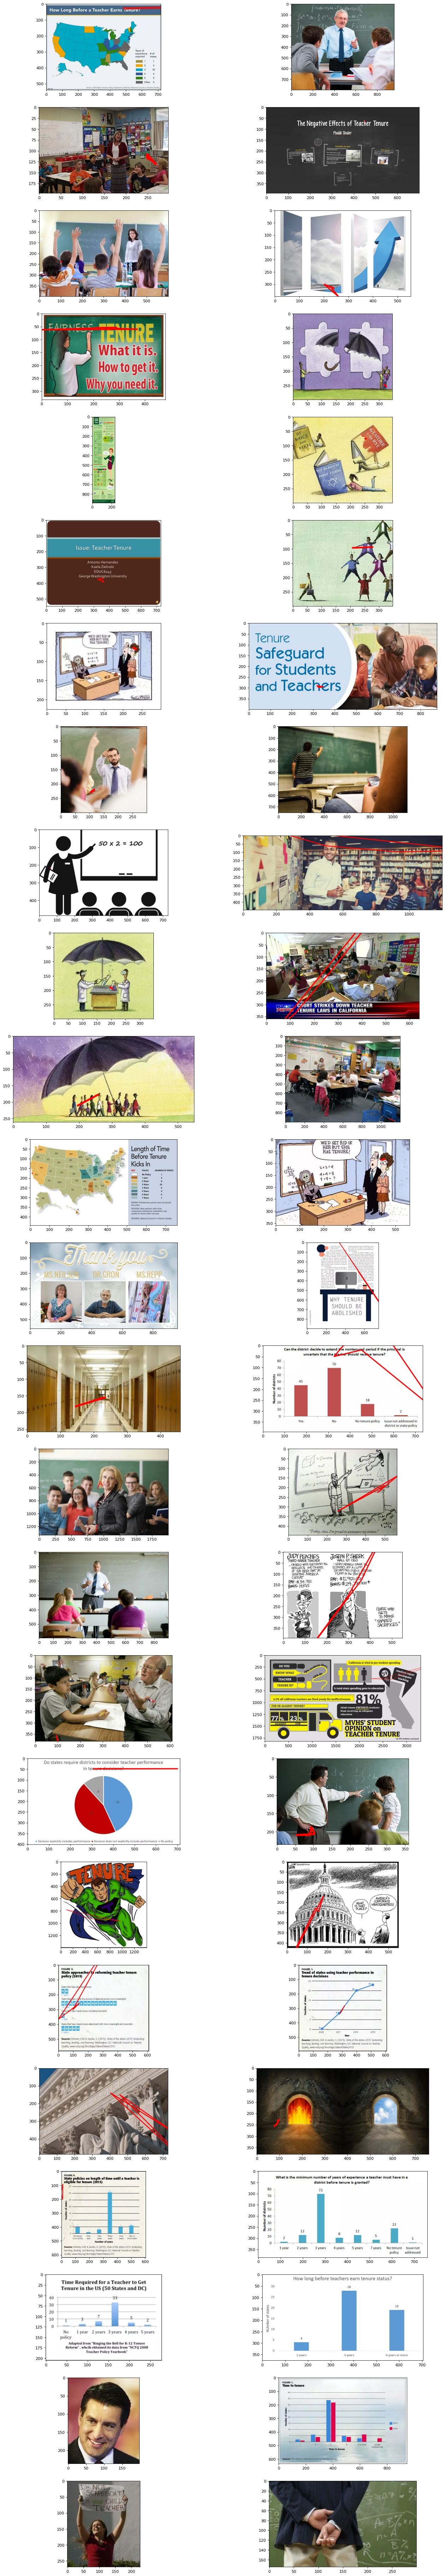

In [50]:
queries = load_queries()

preselection_data = retrieve(queries.iloc[[0]])

image_paths = load_image_paths(preselection_data["docno"])
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

sorted_images = get_sorted_images(images)
show_multiple_images(sorted_images, 25, 2)

In [47]:
sorted_images